In [26]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm


Sets training configurations and loads the ProstateX labels. It ensures only patients with
corresponding preprocessed .npy volume files are included in the dataset.

In [28]:

# === Config ===
DATA_DIR = r"C:\Users\anude\Downloads\processed_data"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
BATCH_SIZE = 4
EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load labels and volume paths ===
df = pd.read_csv(FINDINGS_CSV)
df = df.dropna(subset=['ClinSig'])
df['ProxID'] = df['ProxID'].astype(str)
df['ClinSig'] = df['ClinSig'].astype(int)

# Only use IDs that have .npy files
available_ids = {f.replace(".npy", "") for f in os.listdir(DATA_DIR)}
df = df[df['ProxID'].isin(available_ids)]


In [29]:
#Functions

def resize_volume(vol, target_shape=(3, 64, 64, 64)):
    """
    Resizes a 4D volume by cropping or zero-padding to match the target shape.
    Ensures consistent input dimensions for model training.
    """
    c, d, h, w = vol.shape
    tc, td, th, tw = target_shape
    padded = np.zeros(target_shape, dtype=np.float32)
    
    # Crop if too big
    d = min(d, td)
    h = min(h, th)
    w = min(w, tw)

    padded[:c, :d, :h, :w] = vol[:c, :d, :h, :w]
    return padded

def load_tensor_dataset(dataframe, target_shape=(3, 64, 64, 64)):
    """
    Loads and resizes volumes from .npy files, stacks them into tensors,
    and returns a TensorDataset of image volumes and binary labels.
    """
    x_list, y_list = [], []
    for _, row in dataframe.iterrows():
        try:
            vol = np.load(os.path.join(DATA_DIR, f"{row['ProxID']}.npy")).astype(np.float32)
            vol = resize_volume(vol, target_shape)
            x_list.append(vol)
            y_list.append(row['ClinSig'])
        except Exception as e:
            print(f"[ERROR] Skipping {row['ProxID']}: {e}")
    x_tensor = torch.tensor(np.stack(x_list))  # [N, 3, 64, 64, 64]
    y_tensor = torch.tensor(y_list, dtype=torch.float32)
    return TensorDataset(x_tensor, y_tensor)


Splits the dataset into stratified training and validation sets based on ClinSig, loads them as tensor datasets, and prepares PyTorch DataLoaders for model training and evaluation.

In [31]:
# Split into train/val
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClinSig'], random_state=42)

train_data = load_tensor_dataset(train_df)
val_data = load_tensor_dataset(val_df)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

A simple 3D CNN for binary classification of prostate lesions is trained using binary cross-entropy loss. After each epoch, the training loss is printed, and the model learns to predict clinical significance from the preprocessed 3D volumes.

In [33]:
# === Define model ===
model = nn.Sequential(
    nn.Conv3d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Flatten(),
    nn.Linear(32 * 16 * 16 * 16, 128),  # adjust if input shape is different
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(DEVICE)

# === Training ===
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.BCELoss()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x_batch).squeeze()
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

# === Save model ===
MODEL_PATH = r"C:\Users\anude\Downloads\project\prostate_cnn_model_3d.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f" Model saved to {MODEL_PATH}")


Epoch 1/10: 100%|██████████| 29/29 [00:03<00:00,  8.60it/s]


Epoch 1 - Loss: 16.0126


Epoch 2/10: 100%|██████████| 29/29 [00:03<00:00,  8.71it/s]


Epoch 2 - Loss: 15.4384


Epoch 3/10: 100%|██████████| 29/29 [00:03<00:00,  8.72it/s]


Epoch 3 - Loss: 14.4914


Epoch 4/10: 100%|██████████| 29/29 [00:03<00:00,  8.67it/s]


Epoch 4 - Loss: 14.1233


Epoch 5/10: 100%|██████████| 29/29 [00:03<00:00,  8.65it/s]


Epoch 5 - Loss: 13.6600


Epoch 6/10: 100%|██████████| 29/29 [00:03<00:00,  8.72it/s]


Epoch 6 - Loss: 13.0406


Epoch 7/10: 100%|██████████| 29/29 [00:03<00:00,  8.67it/s]


Epoch 7 - Loss: 12.8113


Epoch 8/10: 100%|██████████| 29/29 [00:03<00:00,  8.62it/s]


Epoch 8 - Loss: 14.0870


Epoch 9/10: 100%|██████████| 29/29 [00:03<00:00,  8.66it/s]


Epoch 9 - Loss: 11.4950


Epoch 10/10: 100%|██████████| 29/29 [00:03<00:00,  8.66it/s]


Epoch 10 - Loss: 10.8940
 Model saved to C:\Users\anude\Downloads\project\prostate_cnn_model_3d.pth


Loads the saved 3D CNN model and evaluates its predictions on the validation set, calculating classification metrics like precision, recall, and F1-score for ClinSig and non-ClinSig cases.

In [35]:
# === Load saved model ===
MODEL_PATH = r"C:\Users\anude\Downloads\project\prostate_cnn_model_3d.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# === Evaluation ===
all_preds, all_labels = [], []
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        preds = model(x_batch).squeeze().cpu().numpy()
        preds = (preds > 0.5).astype(int)
        all_preds += [int(preds)] if np.isscalar(preds) else preds.tolist()
        all_labels += [int(y_batch)] if torch.numel(y_batch) == 1 else y_batch.numpy().tolist()

print("\n📊 Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["Not ClinSig", "ClinSig"]))



📊 Evaluation Report:
              precision    recall  f1-score   support

 Not ClinSig       0.79      0.96      0.86        23
     ClinSig       0.00      0.00      0.00         6

    accuracy                           0.76        29
   macro avg       0.39      0.48      0.43        29
weighted avg       0.62      0.76      0.68        29



Visualises the confusion matrix to assess how well the model distinguishes between clinically significant and non-significant lesions.

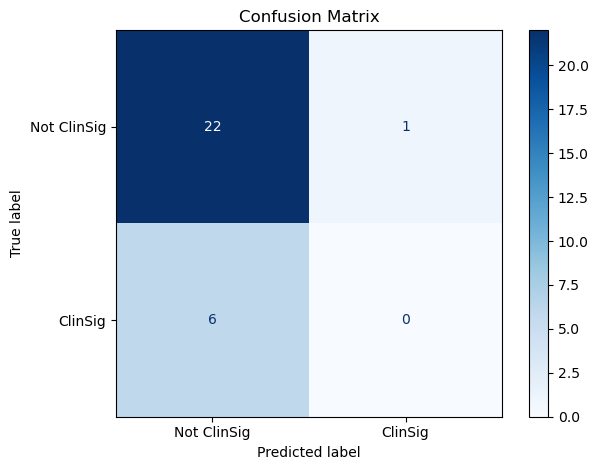

In [37]:
# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


<h2> Improving the accuracy and precision

Adding focal loss, data augmentation, and oversampling of clinically significant cases to handle class imbalance. It uses a deeper CNN architecture with batch normalization, dropout, and a learning rate scheduler for better generalisation

In [40]:
GAMMA = 3.0
THRESHOLD = 0.5
TARGET_SHAPE = (3, 64, 64, 64)
EPOCHS = 30

# === Data prep ===
df = pd.read_csv(FINDINGS_CSV)
df = df.dropna(subset=['ClinSig'])
df['ProxID'] = df['ProxID'].astype(str)
df['ClinSig'] = df['ClinSig'].astype(int)
df['ProxID'] = df['ProxID'].apply(lambda x: x if x.startswith("ProstateX-") else f"ProstateX-{x}")
available_ids = {f.replace(".npy", "") for f in os.listdir(DATA_DIR)}
df = df[df['ProxID'].isin(available_ids)]


In [41]:
# === Focal Loss ===
def focal_loss(logits, targets, gamma=GAMMA):
    """
    Computes Focal Loss to address class imbalance by focusing more on hard-to-classify examples.
    """
    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    pt = torch.exp(-bce)
    return ((1 - pt) ** gamma * bce).mean()


# === Augmentation ===
def augment(volume):
    """
    Applies random 3D augmentations to a volume: horizontal flip, vertical flip, and 90-degree rotations.
    """
    if random.random() < 0.5:
        volume = np.flip(volume, axis=2)  # Horizontal
    if random.random() < 0.5:
        volume = np.flip(volume, axis=3)  # Vertical
    if random.random() < 0.5:
        k = random.choice([1, 2, 3])
        volume = np.rot90(volume, k, axes=(2, 3)).copy()
    return volume


# === Resize + optional augment ===
def resize_volume(vol, target_shape, augment_flag=False):
    """
    Resizes a volume to the target shape by cropping or zero-padding, with optional augmentation.
    """
    if augment_flag:
        vol = augment(vol)
    c, d, h, w = vol.shape
    tc, td, th, tw = target_shape
    padded = np.zeros(target_shape, dtype=np.float32)
    d, h, w = min(d, td), min(h, th), min(w, tw)
    padded[:c, :d, :h, :w] = vol[:c, :d, :h, :w]
    return padded


# === Data loader with augment for ClinSig ===
def load_tensor_dataset(df, shape=TARGET_SHAPE, augment_clinsig=False):
    """
    Loads volume data and labels into a TensorDataset, applying augmentation only to ClinSig-positive samples.
    Returns the dataset and associated patient IDs.
    """
    x_list, y_list, ids = [], [], []
    for _, row in df.iterrows():
        try:
            vol = np.load(os.path.join(DATA_DIR, f"{row['ProxID']}.npy")).astype(np.float32)
            is_clinsig = row['ClinSig'] == 1
            vol = resize_volume(vol, shape, augment_flag=augment_clinsig and is_clinsig)
            x_list.append(vol)
            y_list.append(row['ClinSig'])
            ids.append(row['ProxID'])
        except Exception as e:
            print(f"[ERROR] Skipping {row['ProxID']}: {e}")
    x_tensor = torch.tensor(np.stack(x_list))
    y_tensor = torch.tensor(y_list, dtype=torch.float32)
    return TensorDataset(x_tensor, y_tensor), ids


In [42]:

# === Train/val split + duplicate ClinSig once ===
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClinSig'], random_state=42)
clinsig_df = train_df[train_df['ClinSig'] == 1]
train_df = pd.concat([train_df, clinsig_df], ignore_index=True)

# === Display counts ===
print("Train class distribution:\n", train_df['ClinSig'].value_counts())
print("Val class distribution:\n", val_df['ClinSig'].value_counts())

# === Load Datasets ===
train_data, _ = load_tensor_dataset(train_df, augment_clinsig=True)
val_data, val_ids = load_tensor_dataset(val_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

Train class distribution:
 ClinSig
0    94
1    44
Name: count, dtype: int64
Val class distribution:
 ClinSig
0    23
1     6
Name: count, dtype: int64


In [47]:
#clearing GPU Chache
torch.cuda.empty_cache()


A deep 3D CNN with batch normalization, dropout, and LeakyReLU activations, then trains it using focal loss and a learning rate scheduler. The model is optimised to handle class imbalance and learn robust features from volumetric prostate data.

In [44]:


# === Deep CNN Model ===
model = nn.Sequential(
    nn.Conv3d(3, 16, 3, padding=1), nn.BatchNorm3d(16), nn.LeakyReLU(),
    nn.Conv3d(16, 32, 3, padding=1), nn.BatchNorm3d(32), nn.LeakyReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.LeakyReLU(),
    nn.MaxPool3d(2),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(64 * 16 * 16 * 16, 256), nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1)
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# === Training Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x_batch).squeeze()
        loss = focal_loss(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")
    scheduler.step(total_loss)

# === Save Trained Model ===
MODEL_PATH = r"C:\Users\anude\Downloads\project\prostate_cnn_model_3DCNN.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f" Model saved to {MODEL_PATH}")


Epoch 1/30:   3%|▎         | 1/35 [00:01<00:50,  1.49s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 1.62 GiB is allocated by PyTorch, and 48.79 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Evaluates the model on the validation set using sigmoid-based thresholding and prints a classification report, displays example predictions.

In [ ]:
# === Load Saved Model ===
MODEL_PATH = r"C:\Users\anude\Downloads\project\prostate_cnn_model_3DCNN.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# === Evaluation ===
all_preds, all_labels, all_proxids = [], [], []
index = 0

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        logits = model(x_batch).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > THRESHOLD).astype(int)
        preds = np.atleast_1d(preds)
        y_batch = y_batch.numpy()
        for i in range(len(preds)):
            prox_id = val_ids[index]
            all_proxids.append(prox_id)
            all_preds.append(int(preds[i]))
            all_labels.append(int(y_batch[i]))
            index += 1

# === Report ===
print("\nFinal Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["Not ClinSig", "ClinSig"], zero_division=0))

print("\nSample Predictions:")
for pid, pred, label in zip(all_proxids[:10], all_preds[:10], all_labels[:10]):
    print(f"{pid}: Predicted={pred}, Actual={label}")

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
